# Confusion Matrix, Sensitivity & Specificity

- StatQuest Videos: 
  - Confusion Matrix: https://youtu.be/Kdsp6soqA7o
  - Sensitivity & Specificity: https://youtu.be/vP06aMoz4v8
- SKLearn Docs: https://scikit-learn.org/stable/modules/model_evaluation.html
- Google ML: https://developers.google.com/machine-learning/crash-course/classification/accuracy-precision-recall

The confusion matrix shows what your machine learning algorithm predicted vs. the known truth. It helps evaluate and compare different ML methods by summarizing their performance on test data.

**⚠️ Convention Note**: StatQuest videos use "Rows = predictions, Columns = actual truth" but **sklearn uses the opposite**: "Rows = actual truth, Columns = predictions". This notebook follows sklearn's convention.

In [1]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(n_samples=300, n_features=4, n_classes=2, 
                          n_redundant=0, random_state=42)

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.3, 
    random_state=42
)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((210, 4), (90, 4), (210,), (90,))

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(random_state=42).fit(X_train, y_train)
rf = RandomForestClassifier(random_state=42).fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)
y_pred_rf = rf.predict(X_test)

y_pred_lr.shape, y_pred_rf.shape

((90,), (90,))

## Binary Classification Confusion Matrix

**Important**: Sklearn uses **Rows = True labels, Columns = Predicted labels** (opposite of StatQuest videos!)

For 2-class problems (e.g., has disease / no disease) in sklearn:
- **True Negatives (TN)**: Top-left [0,0] - correctly predicted negative cases  
- **False Positives (FP)**: Top-right [0,1] - incorrectly predicted positive cases (Type I error)
- **False Negatives (FN)**: Bottom-left [1,0] - missed positive cases (Type II error)
- **True Positives (TP)**: Bottom-right [1,1] - correctly predicted positive cases

Diagonal elements = correct predictions, off-diagonal = mistakes

In [3]:
from sklearn.metrics import confusion_matrix

lr_cm = confusion_matrix(y_test, y_pred_lr)
rf_cm = confusion_matrix(y_test, y_pred_rf)

print(f"Logistic Regression Confusion Matrix:")
print(lr_cm)
print(f"\nTP: {lr_cm[1,1]}, TN: {lr_cm[0,0]}, FP: {lr_cm[0,1]}, FN: {lr_cm[1,0]}")

print(f"\n\nRandom Forest Confusion Matrix:")
print(rf_cm)
print(f"\nTP: {rf_cm[1,1]}, TN: {rf_cm[0,0]}, FP: {rf_cm[0,1]}, FN: {rf_cm[1,0]}")

Logistic Regression Confusion Matrix:
[[40  2]
 [ 3 45]]

TP: 45, TN: 40, FP: 2, FN: 3


Random Forest Confusion Matrix:
[[41  1]
 [ 3 45]]

TP: 45, TN: 41, FP: 1, FN: 3


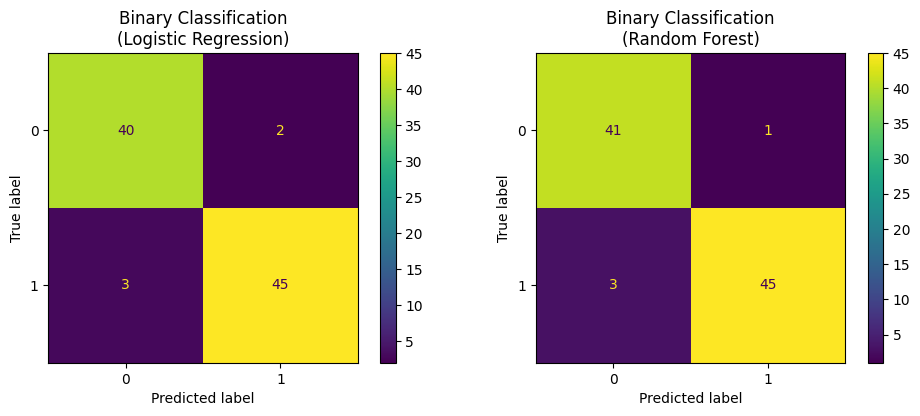

In [4]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

_ = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_lr, ax=ax1)
_ = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf, ax=ax2)

ax1.set_title('Binary Classification\n(Logistic Regression)')
ax2.set_title('Binary Classification\n(Random Forest)')

plt.tight_layout()
plt.show()

## Sensitivity and Specificity

**Sensitivity (Recall, True Positive Rate)**:
- What percentage of actual positives were correctly identified?
- Formula: `TP / (TP + FN)`
- High sensitivity = few false negatives (good at catching positives)
- For applications like disease prediction, correctly identifying the positive cases is crucial. A false negative typically has more serious consequences than a false positive.

**Specificity (True Negative Rate)**:
- What percentage of actual negatives were correctly identified?  
- Formula: `TN / (TN + FP)`
- High specificity = few false positives (good at identifying negatives)

In [5]:
# Calculate sensitivity and specificity manually
def calc_metrics(cm):
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    return sensitivity, specificity

# Random Forest metrics
rf_sens, rf_spec = calc_metrics(rf_cm)
print(f"Random Forest:")
print(f"  Sensitivity: {rf_sens:.3f} ({rf_sens:.1%} of positives correctly identified)")
print(f"  Specificity: {rf_spec:.3f} ({rf_spec:.1%} of negatives correctly identified)")

# Logistic Regression metrics  
lr_sens, lr_spec = calc_metrics(lr_cm)
print(f"\nLogistic Regression:")
print(f"  Sensitivity: {lr_sens:.3f} ({lr_sens:.1%} of positives correctly identified)")
print(f"  Specificity: {lr_spec:.3f} ({lr_spec:.1%} of negatives correctly identified)")

print(f"\nComparison:")
print(f"  Better sensitivity: {'Random Forest' if rf_sens > lr_sens else 'Logistic Regression'}")
print(f"  Better specificity: {'Random Forest' if rf_spec > lr_spec else 'Logistic Regression'}")

Random Forest:
  Sensitivity: 0.938 (93.8% of positives correctly identified)
  Specificity: 0.976 (97.6% of negatives correctly identified)

Logistic Regression:
  Sensitivity: 0.938 (93.8% of positives correctly identified)
  Specificity: 0.952 (95.2% of negatives correctly identified)

Comparison:
  Better sensitivity: Logistic Regression
  Better specificity: Random Forest


## Precision and F1 Score

**Precision**:
- Of all positive predictions, what percentage were actually correct?
- Formula: `TP / (TP + FP)`
- High precision = few false positives (when model says "positive", it's usually right)

**F1 Score**:
- Harmonic mean of precision and recall (sensitivity)
- Formula: `2 * (Precision * Recall) / (Precision + Recall)`
- Balances precision and recall - useful when you need both to be high
- Range: 0 to 1, where 1 is perfect


In [14]:
# Calculate precision and F1 score manually
def calc_precision_f1(cm):
    tn, fp, fn, tp = cm.ravel()
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0  # recall = sensitivity
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    return precision, recall, f1

# Random Forest metrics
rf_prec, rf_rec, rf_f1 = calc_precision_f1(rf_cm)
print(f"Random Forest:")
print(f"  Precision: {rf_prec:.3f} ({rf_prec:.1%} of positive predictions were correct)")
print(f"  Recall (Sensitivity): {rf_rec:.3f} ({rf_rec:.1%} of actual positives found)")
print(f"  F1 Score: {rf_f1:.3f}")

# Logistic Regression metrics  
lr_prec, lr_rec, lr_f1 = calc_precision_f1(lr_cm)
print(f"\nLogistic Regression:")
print(f"  Precision: {lr_prec:.3f} ({lr_prec:.1%} of positive predictions were correct)")
print(f"  Recall (Sensitivity): {lr_rec:.3f} ({lr_rec:.1%} of actual positives found)")
print(f"  F1 Score: {lr_f1:.3f}")

print(f"\nComparison:")
print(f"  Better precision: {'Random Forest' if rf_prec > lr_prec else 'Logistic Regression'}")
print(f"  Better F1 score: {'Random Forest' if rf_f1 > lr_f1 else 'Logistic Regression'}")

# Trade-offs explanation
print(f"\nTrade-offs:")
print(f"  Random Forest: Higher precision ({rf_prec:.3f} vs {lr_prec:.3f}) - fewer false positives")
print(f"  Logistic Regression: Same recall ({lr_rec:.3f}) - both find same % of actual positives")


Random Forest:
  Precision: 0.978 (97.8% of positive predictions were correct)
  Recall (Sensitivity): 0.938 (93.8% of actual positives found)
  F1 Score: 0.957

Logistic Regression:
  Precision: 0.957 (95.7% of positive predictions were correct)
  Recall (Sensitivity): 0.938 (93.8% of actual positives found)
  F1 Score: 0.947

Comparison:
  Better precision: Random Forest
  Better F1 score: Random Forest

Trade-offs:
  Random Forest: Higher precision (0.978 vs 0.957) - fewer false positives
  Logistic Regression: Same recall (0.938) - both find same % of actual positives


## Multi-Class Classification

For 3+ classes, confusion matrices get larger (e.g., 3x3 for 3 classes). Key differences:
- **No single sensitivity/specificity** for the entire matrix
- Calculate **separate metrics for each class** 
- For each class: treat it as "positive" and all others as "negative"
- Diagonal still shows correct predictions

In [8]:
# Create multi-class dataset (3 classes - like movie preferences)
X_multi, y_multi = make_classification(
    n_samples=400, 
    n_features=4, n_classes=4, 
    n_redundant=0, n_clusters_per_class=1, random_state=42
)

X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(
    X_multi, 
    y_multi, 
    test_size=0.3, 
    random_state=42
)

# Train model and get predictions
rf_multi = RandomForestClassifier(random_state=42).fit(X_train_m, y_train_m)
pred_multi = rf_multi.predict(X_test_m)

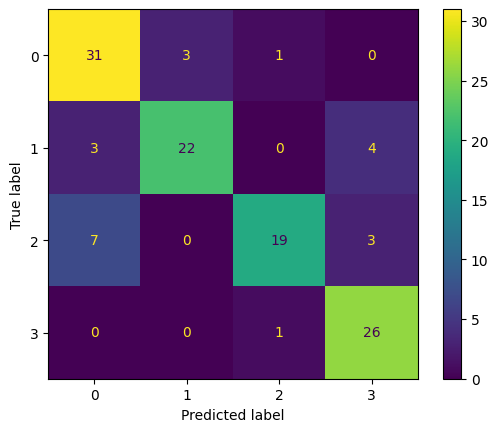

In [9]:
# Multi-class confusion matrix
cm_multi = confusion_matrix(y_test_m, pred_multi)
_ = ConfusionMatrixDisplay.from_predictions(y_test_m, pred_multi)

In [11]:
# Calculate per-class sensitivity and specificity
class_names = ["Class 0", "Class 1", "Class 2", "Class 3"]
for i, class_name in enumerate(class_names):
    # For class i: TP = cm[i,i], FN = sum of row i except diagonal
    tp = cm_multi[i, i]
    fn = cm_multi[i, :].sum() - tp
    fp = cm_multi[:, i].sum() - tp  
    tn = cm_multi.sum() - tp - fn - fp
    
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    print(f"\n{class_name}:")
    print(f"  Sensitivity: {sensitivity:.3f} ({sensitivity:.1%} of {class_name} correctly identified)")
    print(f"  Specificity: {specificity:.3f} ({specificity:.1%} of non-{class_name} correctly identified)")


Class 0:
  Sensitivity: 0.886 (88.6% of Class 0 correctly identified)
  Specificity: 0.882 (88.2% of non-Class 0 correctly identified)

Class 1:
  Sensitivity: 0.759 (75.9% of Class 1 correctly identified)
  Specificity: 0.967 (96.7% of non-Class 1 correctly identified)

Class 2:
  Sensitivity: 0.655 (65.5% of Class 2 correctly identified)
  Specificity: 0.978 (97.8% of non-Class 2 correctly identified)

Class 3:
  Sensitivity: 0.963 (96.3% of Class 3 correctly identified)
  Specificity: 0.925 (92.5% of non-Class 3 correctly identified)


In [16]:
# Calculate per-class precision and F1 score for multi-class
print("Per-class Precision and F1 Score:")
for i, class_name in enumerate(class_names):
    # For class i: TP = cm[i,i], FN = sum of row i except diagonal
    tp = cm_multi[i, i]
    fn = cm_multi[i, :].sum() - tp
    fp = cm_multi[:, i].sum() - tp  
    tn = cm_multi.sum() - tp - fn - fp
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    print(f"\n{class_name}:")
    print(f"  Precision: {precision:.3f} ({precision:.1%} of {class_name} predictions were correct)")
    print(f"  Recall: {recall:.3f} ({recall:.1%} of actual {class_name} found)")
    print(f"  F1 Score: {f1:.3f}")

Per-class Precision and F1 Score:

Class 0:
  Precision: 0.756 (75.6% of Class 0 predictions were correct)
  Recall: 0.886 (88.6% of actual Class 0 found)
  F1 Score: 0.816

Class 1:
  Precision: 0.880 (88.0% of Class 1 predictions were correct)
  Recall: 0.759 (75.9% of actual Class 1 found)
  F1 Score: 0.815

Class 2:
  Precision: 0.905 (90.5% of Class 2 predictions were correct)
  Recall: 0.655 (65.5% of actual Class 2 found)
  F1 Score: 0.760

Class 3:
  Precision: 0.788 (78.8% of Class 3 predictions were correct)
  Recall: 0.963 (96.3% of actual Class 3 found)
  F1 Score: 0.867


## Using Sklearn's Built-in Functions

**Note**: The `classification_report()` function automatically calculates all the metrics we computed manually above:
- **Precision**: Accuracy of positive predictions
- **Recall**: Same as sensitivity (true positive rate)  
- **F1-score**: Harmonic mean of precision and recall
- **Support**: Number of samples for each class


Binary Classification Report:
              precision    recall  f1-score   support

  No Disease       0.93      0.98      0.95        42
 Has Disease       0.98      0.94      0.96        48

    accuracy                           0.96        90
   macro avg       0.96      0.96      0.96        90
weighted avg       0.96      0.96      0.96        90



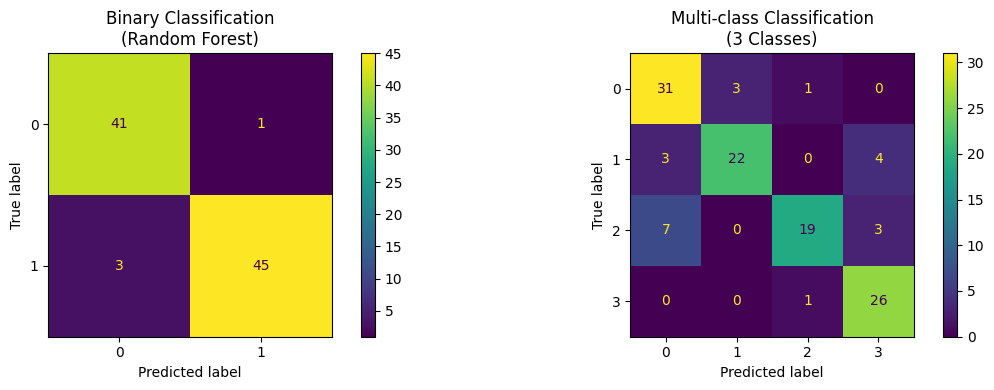


Multi-class Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.89      0.82        35
           1       0.88      0.76      0.81        29
           2       0.90      0.66      0.76        29
           3       0.79      0.96      0.87        27

    accuracy                           0.82       120
   macro avg       0.83      0.82      0.81       120
weighted avg       0.83      0.82      0.81       120



In [13]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Binary classification report (includes sensitivity/specificity)
print("Binary Classification Report:")
print(classification_report(y_test, y_pred_rf, target_names=['No Disease', 'Has Disease']))

# Visual confusion matrix
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf, ax=ax1)
ax1.set_title('Binary Classification\n(Random Forest)')

ConfusionMatrixDisplay.from_predictions(y_test_m, pred_multi, ax=ax2)
ax2.set_title('Multi-class Classification\n(3 Classes)')

plt.tight_layout()
plt.show()

# Multi-class classification report
print("\nMulti-class Classification Report:")
print(classification_report(y_test_m, pred_multi))